## Problem Statement

As price of cold storage have reduced drastically, cloud providers now provides image storage for free(debatable due to privacy issues). Examples are Facebook, Instagram, iCloud and Google photos where photos can be configured to automatically sync to the cloud in the background, so photos are not lost no matter what happens to the phone.

With an onslaught of photos on the web ( 350 Million photos daily on FB, 1.2 billion photos on Google Photos daily), it becomes a challenge to search across all these photos because most photos are not tagged with keywords. Without specific keywords being associated to the photos, the photos are not searchable.



## Data science problem

There are two main ways to solve this problem:
1. Generate keywords through Multi label classification
2. Generate captions 

For this project, we built a model what will automatically generate captions given photos as input. The generated captions can be stored in a search engine such as Elasticsearch / Solr and full text search can be performed on this photos. 


In [1]:
# Execute if pycocotools is not installed
!pip install pycocotools

In [2]:
# Download coco dataset
!wget http://images.cocodataset.org/zips/train2017.zip

--2019-12-04 04:07:31--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.228.136
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.228.136|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  48.5MB/s    in 6m 33s  

2019-12-04 04:14:05 (46.9 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [3]:
# Download validation dataset
!wget http://images.cocodataset.org/zips/val2017.zip

--2019-12-04 04:14:07--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.184.235
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.184.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  46.3MB/s    in 17s     

2019-12-04 04:14:24 (45.0 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [0]:
!mkdir -p coco2017/train2017/
!mkdir -p coco2017/val2017/
!mkdir coco2017-dataset

In [0]:
!unzip -qq val2017.zip -d coco2017/val2017

In [0]:
!unzip -qq train2017.zip -d coco2017/train2017

In [7]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2019-12-04 04:22:52--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.169.115
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.169.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  45.0MB/s    in 5.7s    

2019-12-04 04:22:58 (42.5 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [0]:
!unzip -qq annotations_trainval2017.zip -d coco2017-dataset

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
from pycocotools.coco import COCO

import nltk
nltk.download('punkt')
from torchvision import transforms



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Helper Functions

In [0]:
# Helper functions
from matplotlib import pyplot as plt
import nltk
import os
import torch
import torch.utils.data as data
# from vocabulary import Vocabulary
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json
from collections import Counter

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='',
                data_year = '2017'
              ):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, f'coco2017/train2017/train2017/')
        annotations_file = os.path.join(cocoapi_loc, f'coco2017-dataset/annotations/captions_train{data_year}.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, f'coco2017/val2017/val2017/')
        annotations_file = os.path.join(cocoapi_loc, f'coco2017-dataset/annotations/captions_val{data_year}.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder, 
                          data_year=data_year)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder, data_year='2017'):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file, data_year=data_year)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image
    
    def sample_train_item(self, index):
        '''
        Function to return original image and caption from the training set
        '''
        ann_id = self.ids[index]
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        # Load the target captions of the train image
        caption = self.coco.anns[ann_id]['caption']
        # Load image as numpy array
        PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
        orig_image = np.array(PIL_image)
        return orig_image, caption



    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)
        
        
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train{data_year}.json',
        vocab_from_file=False, 
        data_year='2017'):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        
        #Must set this!
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word) # When a new vocab is build, <start> string is coded as 0
        self.add_word(self.end_word) # <end> is coded as 1
        self.add_word(self.unk_word) # <unk> is coded as 2
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [0]:
# Select appropriate values for the Python variables below.
batch_size = 32          # batch size
vocab_threshold = 3        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file

In [0]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


In [13]:
# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.78s)
creating index...


  0%|          | 860/591753 [00:00<01:08, 8598.14it/s]

index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:57<00:00, 10371.56it/s]


In [67]:
import numpy as np
import torch.utils.data as data

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
# print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

images.shape: torch.Size([32, 3, 224, 224])
captions.shape: torch.Size([32, 13])


## Visualizing the training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

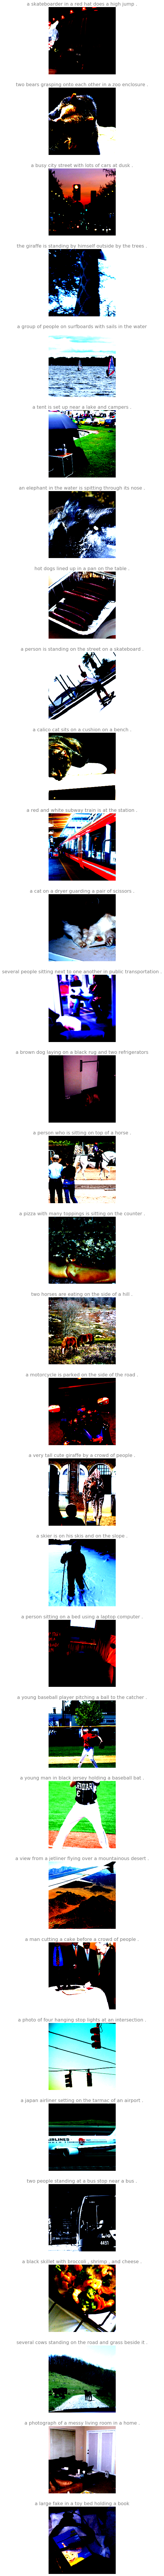

In [68]:
f, ax = plt.subplots(len(images),1, figsize=(15,  len(images)*5))
for i, (img,cap) in enumerate(zip(images,captions)):
#     print(f'img shape:{img.shape} type:{type(img)}, cap type : {type(cap)}, cap:{cap}')
    sentence = ' '.join([data_loader.dataset.vocab.idx2word[token] for token in cap.tolist() if token not in [0,1,2]])

    
    ax[i].imshow(img.permute(1,2,0) )
#     ax[i].set_title(sentence)
    ax[i].set_title(sentence, color='grey', size=16)
    ax[i].set_axis_off()

plt.show()

## Visualizing the captions

In [37]:
[ " ".join([ data_loader.dataset.vocab.idx2word.get(idx.item()) for idx in sen]) for sen in captions]

['<start> a group of available wine glasses are placed on a table . <end>',
 '<start> hot dogs sitting on an red tray next to french fries . <end>',
 '<start> two young women sit on an easy chair on the sidewalk . <end>',
 '<start> the man is playing a game of tennis on the court . <end>',
 '<start> an interstate exit sign with a stop sign next to it . <end>',
 '<start> a bird perches on a concrete finial amid green garden shrubs . <end>',
 '<start> computer mouse and a keyboard sitting on top of a desk . <end>',
 '<start> a person behind a pile of stuff in an industrial kitchen . <end>',
 '<start> a red trolley passing by a group of people under umbrellas . <end>',
 '<start> a bird enjoys a free pizza on top of a newspaper stand <end>',
 '<start> the pitcher for the brewers was warming up in the bullpen . <end>',
 '<start> a woman in high heels walking a dog on a leash . <end>',
 '<start> two giraffes are chewing on a branch hanging from a pole . <end>',
 '<start> a person on a skateb

## Modelling

In [38]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torch.optim import Adam
import math

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Loaded the pre trained resnet model. can use 50 or 18(faster)
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        # Taking all the front layers except the last
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Create an  linear layer of size: First dimension of the dropped fully connected layer, and embedding size, so it can be fed into the next RNN embedding layer
        # Same with list(resnet.children())[-1]
        self.embed = nn.Linear(resnet.fc.in_features, embed_size) # use this for resnet

        
        

    def forward(self, images):
        features = self.resnet(images)
        # Flatten to fully connected layer
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, drop_prob=0.2):
        super(DecoderRNN, self).__init__()
#         self.hidden_size = hidden_size
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers = num_layers, batch_first=True, dropout=drop_prob)
        self.dropout = nn.Dropout(drop_prob) # Add a dropout layer
        self.scores = nn.Linear(self.lstm.hidden_size, vocab_size) 
        
        #Initilize weights
        self.init_weights()
    
    def init_weights(self):
        '''
        Initialize the weights for the word embedding layer and the final FC layer
        '''
#         torch.nn.init.xavier_uniform_(self.scores.weight)
#         torch.nn.init.xavier_uniform_(self.word_embeddings.weight)

        # Set bias tensor to all 0.01
        self.scores.bias.data.fill_(0.01)
        # FC weights as xavier normal
        torch.nn.init.xavier_normal_(self.scores.weight)

        # init forget gate bias to 1
        for names in self.lstm._all_weights:
            for name in filter(lambda n: "bias" in n,  names):
                bias = getattr(self.lstm, name)
                n = bias.size(0)
                start, end = n//4, n//2
                bias.data[start:end].fill_(1.)

    
    def forward(self, features, captions):
        embeddings = self.word_embeddings(captions[:,:-1]) # Discarding the last token because we don't want the decoder to be predicting past the last time step
        # Now add the feature vector  as the first step of the training,
        # The current shape for word_embeddings is 10, 14 , 256, we will transform it to (batch_size, 13, 256) 
        # input features from cnn is in the shape of (batch_size, 256) (need to add one dimension by unsqueeze at the 1st dimension
        # features.unsqueez(1) creates a tensor of shape (batch_size, 1, 256) , which can be concatenated with (batch_size, 12, 256) at dim = 1
        # The way to add the features from CNN into the embeddings as the first step is by concatenating the matrix
        lstm_input = torch.cat([features.unsqueeze(1), embeddings],dim=1)
        # Now lstm_input is of shape (batch_size, 14, 256 )
        
        out, (hidden, cell) = self.lstm(lstm_input)
        # Output refers to the hidden state of the last RNN, which is equivalent to hidden[:,-1 ,:] (batch, layers, hidden_nodes)
        # Add a dropout layer
        out = self.dropout(out)
        output = self.scores(out)
#         output.view(seq_len, batch, num_directions, hidden_size)
#         print(f'Shapes: out:{out.shape}, output:{output.shape} hidden:{hidden.shape} cell:{cell.shape}')
        return output
        
    

    def predict(self, inputs, states=None, max_len=20):
        # Not using word embeddings layer as there are no text input
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
#         print("Decoder sample")
        output_tokens = []
        _input = inputs
        for i in range(max_len):
#             print(f"Lstm Input shape:{_input.shape}")  # [1, 1, 256]
            
            out, states = self.lstm(_input, states)
#             print(f"out after lstm:{out.shape} ") # [1, 1, 256]
            out = self.scores(out.squeeze(1))
#             print(f"out after scores:{out.shape} ") # [1, 10330]
            
            
#             tensor_list = sorted([ (i, t.item()) for i, t in enumerate(out[0,:])], key=lambda x:x[1], reverse=True)
#             print(tensor_list[:5])
            token = out.argmax(dim=1)
            output_tokens.append(token.item())
            token_reshaped = token.unsqueeze(0)
            _input = self.word_embeddings(token_reshaped)
  
        
        return output_tokens


# Move tensor to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("GPU:",torch.cuda.get_device_name(0))

GPU: Tesla P100-PCIE-16GB


In [0]:
# Select appropriate values for the Python variables below.
batch_size = 32          # batch size
vocab_threshold = 3        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512         # number of features in hidden state of the RNN decoder
num_epochs = 6             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
num_layers=2
drop_prob=0.4
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity



In [0]:
# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [0]:
# Build data loader if batch_size, transformer, vocab threshold changed
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.09s)
creating index...


  0%|          | 680/591753 [00:00<01:26, 6799.36it/s]

index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:07<00:00, 8751.46it/s]


In [41]:
# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Create the test data loader.
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                          # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])



test_loader = get_loader(transform=transform_test,    
                         mode='test', batch_size=1)
# Obtain sample image before and after pre-processing.
# orig_image, image = next(iter(test_loader))
# orig_image.shape, image.shape

# # Visualize sample image, before pre-processing.
# plt.imshow(np.squeeze(orig_image))
# plt.title('example image')
# plt.show()

Vocabulary successfully loaded from vocab.pkl file!


In [0]:
def get_text(_in, vocab_file = test_loader.dataset.vocab, stop=True):
    sentence = []
    for token in _in:
        word = vocab_file.idx2word.get(token)
        if word == "." or word == "<end>":
            sentence.append(".")
            if stop:
                break
        elif word == "<start>":
            pass
        else:
            sentence.append(word)
    return " ".join(sentence).capitalize()

In [43]:


def test_model():
    # Flat model testing
    resnet = models.resnet18(pretrained=True)

    # Taking all the front layers except the last
    t_modules = list(resnet.children())[:-1]
    t_resnet = nn.Sequential(*t_modules)

    # Create an  linear layer of size: First dimension of the dropped fully connected layer, and embedding size, so it can be fed into the next RNN embedding layer
    # Same with list(resnet.children())[-1]
    t_embed = nn.Linear(resnet.fc.in_features, embed_size)

    
    # Encoder Forward
    t_features = t_resnet(images)
    # Flatten to fully connected layer
    t_features = t_features.view(t_features.size(0), -1)

    # Add a linear layer after resnet
    t_features_out = t_embed(t_features)

    print(f"t_features_shape :{t_features.shape} : Flattened features after resnet\nt_features_out:{t_features_out.shape}(batch, embed_size)")
    print("\nDecoder\n")

    # Decoder init
    t_word_embeddings = nn.Embedding(vocab_size, embed_size)
    t_lstm = nn.LSTM(embed_size, hidden_size, num_layers = num_layers, batch_first=True, dropout=drop_prob)
    t_scores = nn.Linear(hidden_size, vocab_size) 
    t_dropout = nn.Dropout(drop_prob)
    
    # Decoder forward
    t_embeddings = t_word_embeddings(captions[:,:-1]) # Discarding the last token <end>  because we will add the features vector as the first step instead
    # Now add the feature vector  as the first step of the training,
    # The current shape for word_embeddings is 10, 12 , 256, we will transform it to (10, 13, 256) 
    # input features from cnn is in the shape of 10, 256 (need to add one dimension by unsqueeze at the 1st dimension
    # features.unsqueez(1) creates a tensor of shape (10, 1, 256) , which can be concatenated with (10, 12, 256) at dim = 1
    # The way to add the features from CNN into the embeddings as the first step is by concating the matrix
    
    lstm_input = torch.cat([t_features_out.unsqueeze(1), t_embeddings],dim=1)
    # Now lstm_input is of shape (batch_size, 13, 256 )

    lstm_out, (lstm_out_hidden, lsm_out_cell) = t_lstm(lstm_input)
    # Output refers to the hidden state of the last RNN, which is equivalent to hidden[:,-1 ,:] (batch, layers, hidden_nodes)
    # Add a dropout layer
    lstm_out = t_dropout(lstm_out)
    scores_out = t_scores(lstm_out)
    print(f"t_embeddings: {t_embeddings.shape} Embedding output after discarding last <END> step\
    \nlstm_input: {lstm_input.shape} Concated t_features_out vector to first step of LSTM before <START> , fed into LSTM\
    \nlstm_out: {lstm_out.shape} LSTM output of the last layer across all steps (batch size, steps, lstm_hidden_nodes), fed into FC layer\
    \nscores_out:{scores_out.shape} (hidden_size, vocab_size)")
    #         output.view(seq_len, batch, num_directions, hidden_size)
    #         print(f'Shapes: out:{out.shape}, output:{output.shape} hidden:{hidden.shape} cell:{cell.shape}')
    
    # Predictions
    print("\nDecoder Sampling\n")
    
    output_tokens = []
#     print(f"t_features_out shape:{t_features_out.shape}, reshaped:{t_features_out[0].unsqueeze(0).unsqueeze(0).shape}")
    _input = t_features_out[0].unsqueeze(0).unsqueeze(0)
    for i in range(20):
#         print(f"Lstm Input shape:{_input.shape}")  # [1, 1, 256]

        out, _= t_lstm(_input)
#         print(f"out after lstm:{out.shape} ") # [1, 1, 256]
        out = t_scores(out)
        
        out = out.squeeze(0)
#         print(f"out after scores squeezed:{out.shape} ") # [64, 10330]
        tensor_list = sorted([ (i, t.item()) for i, t in enumerate(out[0,:])], key=lambda x:x[1], reverse=True)
#         print(tensor_list[:5])
        token = out.argmax(dim=1)
        
#         print(f"argmax on out after scores {token.shape}")

        output_tokens.append(token.item())
        token_reshaped = token.unsqueeze(0)
#         print(f"token value:{token.item()}, reshaped:{token_reshaped.shape}")
        _input = t_word_embeddings(token_reshaped)
#         _input = _input.unsqueeze(0)
#         print(f"_input shape after unsqueeze{_input.shape}")
    
    print(get_text(output_tokens))
    
test_model()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 32.4MB/s]


t_features_shape :torch.Size([32, 512]) : Flattened features after resnet
t_features_out:torch.Size([32, 512])(batch, embed_size)

Decoder

t_embeddings: torch.Size([32, 13, 512]) Embedding output after discarding last <END> step    
lstm_input: torch.Size([32, 14, 512]) Concated t_features_out vector to first step of LSTM before <START> , fed into LSTM    
lstm_out: torch.Size([32, 14, 512]) LSTM output of the last layer across all steps (batch size, steps, lstm_hidden_nodes), fed into FC layer    
scores_out:torch.Size([32, 14, 13423]) (hidden_size, vocab_size)

Decoder Sampling

Ridge merchants toward fixtures domestic doves wondering completed meets numbered saddlebags lilac dusk pepsi para-sails gilded watered wishes flooding artifact


## Initialize the Encoder and Decoder

In [44]:
# Build the Encoder and Decoder


# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=num_layers, drop_prob=drop_prob)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)


print("Cuda available:", torch.cuda.is_available())

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 

# TODO #4: Define the optimizer.
optimizer = Adam(params)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

# Create output folder to store model
model_folder = "models"
if not os.path.exists(model_folder):
    os.mkdir(model_folder)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 226MB/s]


Cuda available: True


In [45]:
for name, param in decoder.named_parameters():
    if param.requires_grad:
        print(f'Param name:{name}')

Param name:word_embeddings.weight
Param name:lstm.weight_ih_l0
Param name:lstm.weight_hh_l0
Param name:lstm.bias_ih_l0
Param name:lstm.bias_hh_l0
Param name:lstm.weight_ih_l1
Param name:lstm.weight_hh_l1
Param name:lstm.bias_ih_l1
Param name:lstm.bias_hh_l1
Param name:scores.weight
Param name:scores.bias


In [46]:
for name, param in encoder.named_parameters():
    if param.requires_grad:
        print(f'Param name:{name}')

Param name:embed.weight
Param name:embed.bias


## Train

In [0]:
curr_epoch=1
epoch_step = 1

In [0]:
from datetime import datetime

# Save model
def save_model(decoder,encoder):
    dt_now =  datetime.now().strftime("%Y-%m-%d")
    last_decoder = f'decoder-{dt_now}_b{batch_size}_vt{vocab_threshold}_embed{embed_size}_hidden{hidden_size}_ep{curr_epoch}_step{epoch_step}.pkl'
    last_encoder = f'encoder-{dt_now}_b{batch_size}_vt{vocab_threshold}_embed{embed_size}_hidden{hidden_size}_ep{curr_epoch}_step{epoch_step}.pkl'
    torch.save(decoder.state_dict(), os.path.join('models', last_decoder ))
    torch.save(encoder.state_dict(), os.path.join('models', last_encoder ))


In [0]:
# Train
import torch.utils.data as data
import numpy as np
import os
import requests
import time

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()


for epoch in range(curr_epoch, num_epochs+1):
    
    for i_step in range(epoch_step, total_step+1):
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients (this is an accumulator used to change the weights)
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        # outputs shape is transformed from (torch.Size([32, 11, 10330]) to torch.Size([352, 10330]))
        # captions shape is transformed from (torch.Size([32, 11]) to torch.Size([352]))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
        
        # Increase epoch_step
        epoch_step+=1
    
    # Save the weights for every epoch
    if epoch % save_every == 0:
        save_model(decoder, encoder)
        # torch.save(decoder.state_dict(), os.path.join('models', 'decoder-%d.pkl' % epoch))
        # torch.save(encoder.state_dict(), os.path.join('models', 'encoder-%d.pkl' % epoch))
    
    # Increase curr_epoch count
    curr_epoch += 1
    
# Close the training log file.
f.close()

Epoch [1/6], Step [100/18493], Loss: 4.6802, Perplexity: 107.7931
Epoch [1/6], Step [200/18493], Loss: 4.7316, Perplexity: 113.4715
Epoch [1/6], Step [300/18493], Loss: 4.4162, Perplexity: 82.7776
Epoch [1/6], Step [400/18493], Loss: 3.7988, Perplexity: 44.6494
Epoch [1/6], Step [500/18493], Loss: 3.6632, Perplexity: 38.9870
Epoch [1/6], Step [600/18493], Loss: 3.7636, Perplexity: 43.1027
Epoch [1/6], Step [700/18493], Loss: 3.5102, Perplexity: 33.4562
Epoch [1/6], Step [800/18493], Loss: 3.7037, Perplexity: 40.5982
Epoch [1/6], Step [900/18493], Loss: 3.3725, Perplexity: 29.1525
Epoch [1/6], Step [1000/18493], Loss: 3.5716, Perplexity: 35.5718
Epoch [1/6], Step [1100/18493], Loss: 3.3103, Perplexity: 27.3935
Epoch [1/6], Step [1200/18493], Loss: 3.3961, Perplexity: 29.8479
Epoch [1/6], Step [1300/18493], Loss: 3.5748, Perplexity: 35.6888
Epoch [1/6], Step [1400/18493], Loss: 3.5049, Perplexity: 33.2766
Epoch [1/6], Step [1500/18493], Loss: 3.1486, Perplexity: 23.3028
Epoch [1/6], Step

In [0]:
!nvidia-smi

Tue Nov 26 13:03:39 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [58]:
# Only run this to load trained model if pre-trained model weights is uploaded
!tar -xzvf models.zip

models/
models/decoder-2019-11-26_b32_vt3_embed512_hidden512_ep2_step18494.pkl
models/decoder-2019-11-26_b32_vt3_embed512_hidden512_ep4_step18494.pkl
models/encoder-2019-11-26_b32_vt3_embed512_hidden512_ep2_step18494.pkl
models/decoder-2019-11-26_b32_vt3_embed512_hidden512_ep1_step18494.pkl
models/encoder-2019-11-26_b32_vt3_embed512_hidden512_ep6_step18494.pkl
models/encoder-2019-11-26_b32_vt3_embed512_hidden512_ep4_step18494.pkl
models/decoder-2019-11-26_b32_vt3_embed512_hidden512_ep5_step18494.pkl
models/decoder-2019-11-26_b32_vt3_embed512_hidden512_ep3_step18494.pkl
models/encoder-2019-11-26_b32_vt3_embed512_hidden512_ep3_step18494.pkl
models/encoder-2019-11-26_b32_vt3_embed512_hidden512_ep1_step18494.pkl
models/encoder-2019-11-26_b32_vt3_embed512_hidden512_ep5_step18494.pkl
models/decoder-2019-11-26_b32_vt3_embed512_hidden512_ep6_step18494.pkl


# Evaulation

In [61]:
# Generate Predictions
# Specify the saved models to load.


# encoder_file = os.path.join(model_base, last_encoder)
# decoder_file = os.path.join(model_base, last_decoder)

encoder_file = '/content/models/encoder-2019-11-26_b32_vt3_embed512_hidden512_ep5_step18494.pkl'
decoder_file = '/content/models/decoder-2019-11-26_b32_vt3_embed512_hidden512_ep5_step18494.pkl'


# Select appropriate values for the Python variables below.
# embed_size = 512
# hidden_size = 512

# The size of the vocabulary.
# vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
eval_encoder = EncoderCNN(embed_size)
eval_encoder.eval()
eval_decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=num_layers)
eval_decoder.eval()

# Load the trained weights.
if torch.cuda.is_available(): 
    eval_decoder.load_state_dict(torch.load(decoder_file))
    eval_encoder.load_state_dict(torch.load(encoder_file))
else:
    eval_decoder.load_state_dict(torch.load(decoder_file, map_location='cpu'))
    eval_encoder.load_state_dict(torch.load(encoder_file, map_location='cpu'))
print(f"Encoder loaded from:{encoder_file}\nDecoder loaded from:{decoder_file}")
# Move models to GPU if CUDA is available.
eval_encoder.to(device)
eval_decoder.to(device)

Encoder loaded from:/content/models/encoder-2019-11-26_b32_vt3_embed512_hidden512_ep5_step18494.pkl
Decoder loaded from:/content/models/decoder-2019-11-26_b32_vt3_embed512_hidden512_ep5_step18494.pkl


DecoderRNN(
  (word_embeddings): Embedding(13423, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (scores): Linear(in_features=512, out_features=13423, bias=True)
)

In [0]:
def get_prediction(i=0, save = False, dataset='val'):
    if dataset=='val':
      orig_image, image = next(iter(test_loader))
    else:
      image, _ = next(iter(data_loader))
      image = image[0,:,:,:].unsqueeze(0)
      orig_image = image.permute(0,2,3,1)
    image = image.to(device)
    features = eval_encoder(image).unsqueeze(1)
    output = eval_decoder.predict(features)    
    sentence = get_text(output)
    
    plt.figure(figsize=(12,10))
    ax = plt.axes() 
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Hide ticks
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    plt.imshow(np.squeeze(orig_image))
    plt.xlabel(sentence,fontsize=15, color="white")
    if save:
        plt.savefig(f'samples/sample_{i:03}.png',bbox_inches='tight')
    plt.show()
    

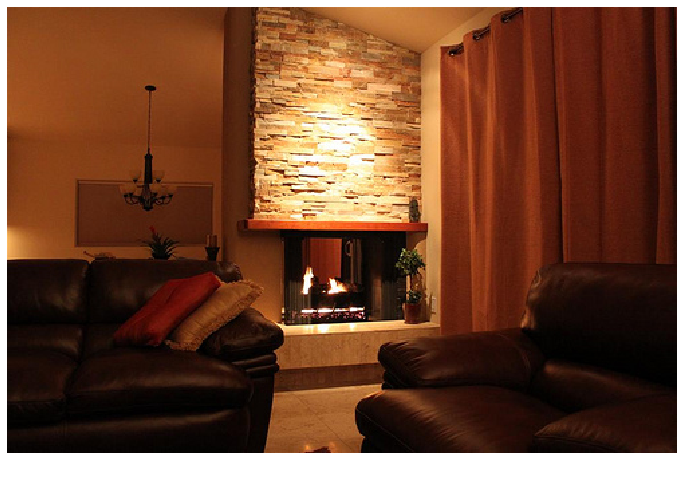

In [64]:
get_prediction()

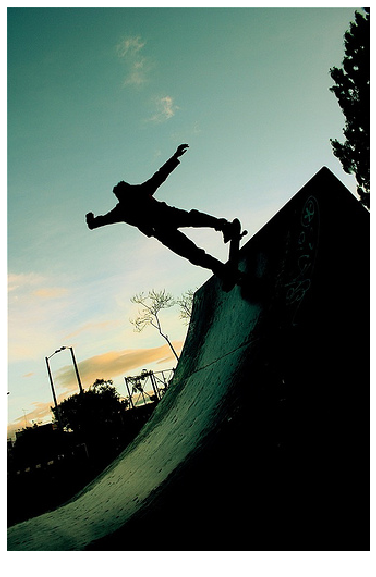

In [0]:
get_prediction()

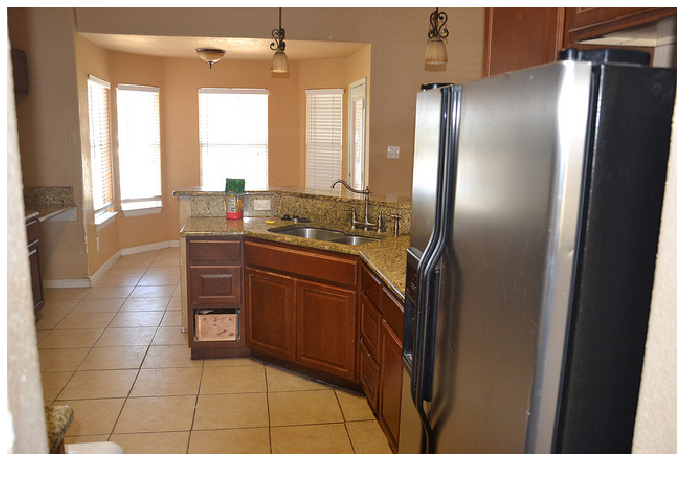

In [0]:
get_prediction()

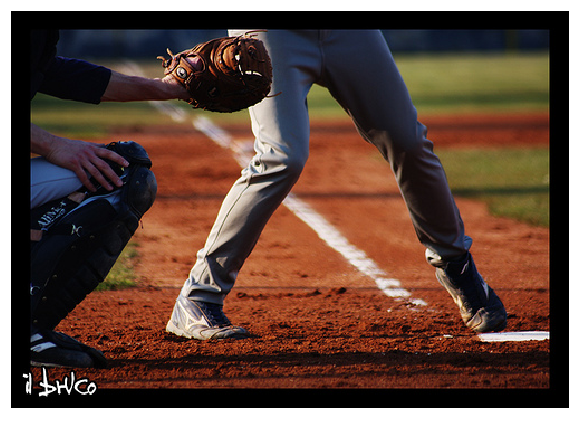

In [0]:
get_prediction()

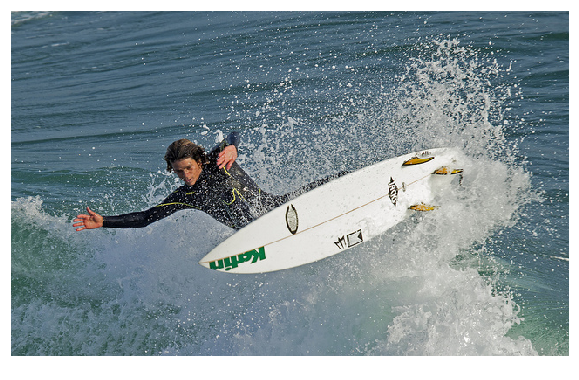

In [0]:
get_prediction()

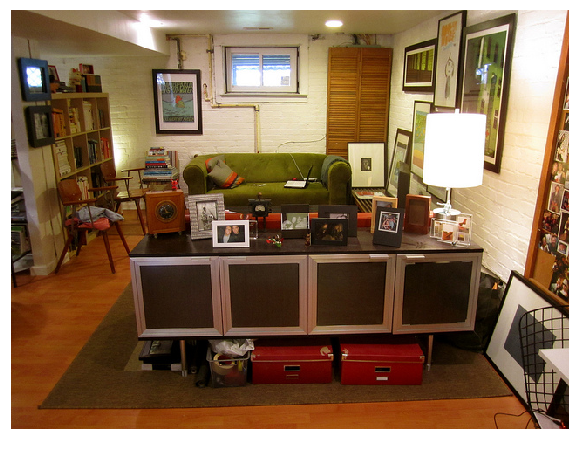

In [0]:
get_prediction()

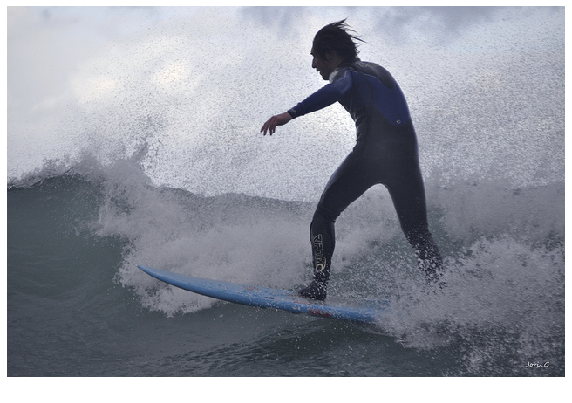

In [0]:
get_prediction()

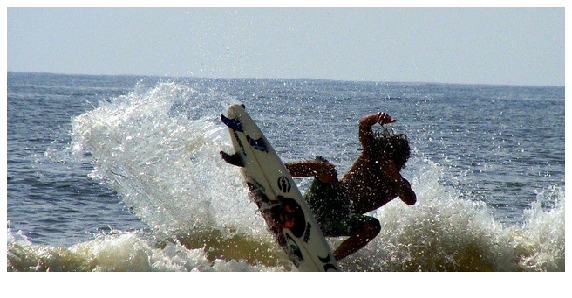

In [0]:
get_prediction()

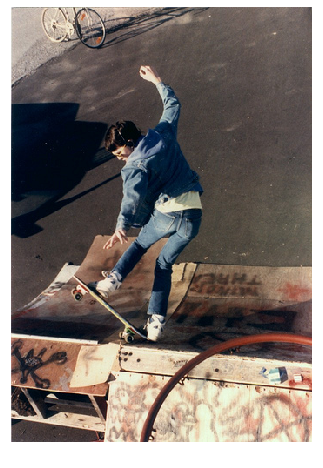

In [0]:
get_prediction()

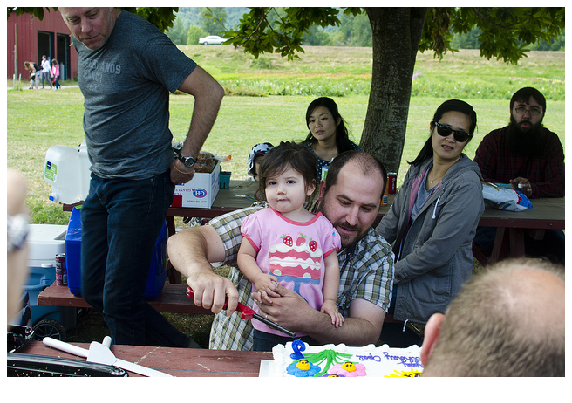

In [0]:
get_prediction()

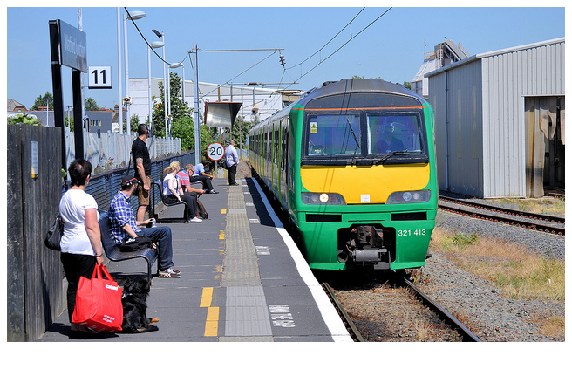

In [0]:
get_prediction()

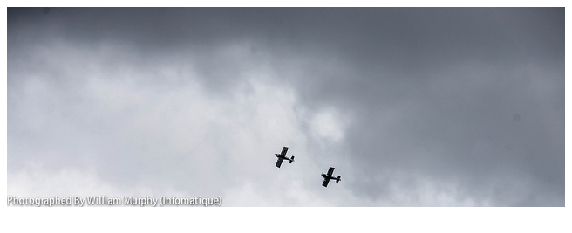

In [0]:
get_prediction()

# Conclusion
In this notebook, we present a model that is able to automatically generate captions given an input image.